# Reinforcement Learning assignment: Worm
### Made by Group 23:
- Kaj de Lange, s1147197
- Troy Dijsselbloem, s1145721
- Julian Dinnissen, s1135596
- Sten Nellen, s1151303

In [46]:
import importlib
import numpy as np
import gymnasium as gym

import dp, mc, td
importlib.reload(dp)
importlib.reload(mc)
importlib.reload(td)
from dp import *
from mc import *
from td import *

# Abstract

_insert your abstract here_

# 0. Environment

In [47]:
from environment import MouseEnv
from gymnasium.envs.registration import register

    
register(id="mouse-v0", entry_point="__main__:MouseEnv")


#Create the environment
env = gym.make("mouse-v0")
# Interact with the environment
obs, info = env.reset()
for _ in range(10):
    action = env.action_space.sample() # Random action
    obs, reward, done, truncated, info = env.step(action)
    env.render()
    if done:
        print("Game Over!")
        break
env.close()

      ╭───╮
╭─────╯ h │
│ 0 0 c m │
│ 0 0 0 0 │
│ 0 0 0 0 │
╰─────────╯
      ╭───╮
╭─────╯ h │
│ 0 0 c 0 │
│ 0 0 0 m │
│ 0 0 0 0 │
╰─────────╯
      ╭───╮
╭─────╯ h │
│ 0 0 c m │
│ 0 0 0 0 │
│ 0 0 0 0 │
╰─────────╯
      ╭───╮
╭─────╯ h │
│ 0 c m 0 │
│ 0 0 0 0 │
│ 0 0 0 0 │
╰─────────╯
      ╭───╮
╭─────╯ h │
│ 0 c 0 0 │
│ 0 0 m 0 │
│ 0 0 0 0 │
╰─────────╯
      ╭───╮
╭─────╯ h │
│ 0 c 0 0 │
│ 0 m 0 0 │
│ 0 0 0 0 │
╰─────────╯
      ╭───╮
╭─────╯ h │
│ 0 c 0 0 │
│ 0 0 0 0 │
│ 0 m 0 0 │
╰─────────╯
      ╭───╮
╭─────╯ h │
│ 0 c 0 0 │
│ 0 0 0 0 │
│ 0 m 0 0 │
╰─────────╯
      ╭───╮
╭─────╯ h │
│ 0 c 0 0 │
│ 0 m 0 0 │
│ 0 0 0 0 │
╰─────────╯
      ╭───╮
╭─────╯ h │
│ 0 c 0 0 │
│ 0 0 m 0 │
│ 0 0 0 0 │
╰─────────╯


c:\Users\User\Documents\GitHub\SOW-BKI258-Reinforcement-Learning\.venv\Lib\site-packages\gymnasium\envs\registration.py:636: UserWarning: WARN: Overriding environment mouse-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


# 1. Introduction

_insert your introduction in this cell_

_describe your environment and the problem the agent has to solve_

_describe the objective of the report (e.g. comparing various RL algorithms) and how you are going to accomplish this (research question)_

_don't forget to add plots/images of the environment, can be done via code cells, but also by inserting .png files into the jupyter notebook_

# 2. Dynamic Programming algorithms

First run the Dynamic Programming algorithms (Policy Iteration and Value Iteration) by calling functions from the separate `dp.py` file, and create plots. Then, fill in the cell completing your 'report' within this file.

In [48]:
# Import plotting library
import matplotlib.pyplot as plt

In [49]:
# Algorithm plotting functions

def plot_convergence(y):
    X = range(len(y))
    plt.plot(X, y)
    plt.yscale("log")
    plt.title(r"$\Delta$ per iteration")
    plt.xlabel("Iterations")
    plt.ylabel(r"log($\Delta$)")
    plt.grid()
    
def plot_state_value(Vs: dict):
    values = list(Vs.values())
    bins = 100
    plt.hist(values, bins=bins)
    plt.title("Distribution of state rewards")
    plt.xlabel("Reward")
    plt.ylabel("Frequency")

In [50]:
# Policy plotting function

def plot_policy(policy: dict, title: str = "Policy by cheese position"):
    "Plot the policy as a grid of arrows, one grid per cheese position, showing the action for each mouse position"
    ARROWS = {0: "↑", 1: "→", 2: "↓", 3: "←"}
    rows, cols = MouseEnv.rows, MouseEnv.cols
    position_policy = policy_index_to_positions(policy, rows, cols)
    fig, axes = plt.subplots(rows, cols, figsize=(16, 10), constrained_layout=True)

    for c_row, c_col in np.ndindex(rows, cols):
        ax = axes[c_row, c_col]
        ax.set(xlim=(-0.5, cols - 0.5), ylim=(rows - 0.5, -0.5))
        ax.set_xticks([])
        ax.set_yticks([])

        # Draw cheese position and label
        ax.text(c_col, c_row, "C", ha="center", va="center", fontsize=20, fontweight="bold")

        # Terminal cheese locations are end states, so no action arrows are shown
        if c_col == 0 or c_row == rows - 1:
            ax.add_patch(plt.Rectangle((c_col - 0.5, c_row - 0.5), 1, 1, facecolor="lightpink")) # type: ignore
            continue

        ax.add_patch(plt.Rectangle((c_col - 0.5, c_row - 0.5), 1, 1, facecolor="lightgray")) # type: ignore

        # Draw action arrows for each mouse position
        for m_row, m_col in np.ndindex(rows, cols):
            if (m_row, m_col) == (c_row, c_col):
                continue
            action = position_policy[c_row, c_col, m_row, m_col]
            if not np.isnan(action):
                ax.text(m_col, m_row, ARROWS[int(action)], ha="center", va="center", fontsize=25)

    fig.suptitle(title)
    return fig, axes

Policy Iteration iterations: 11
Final policy stable: True


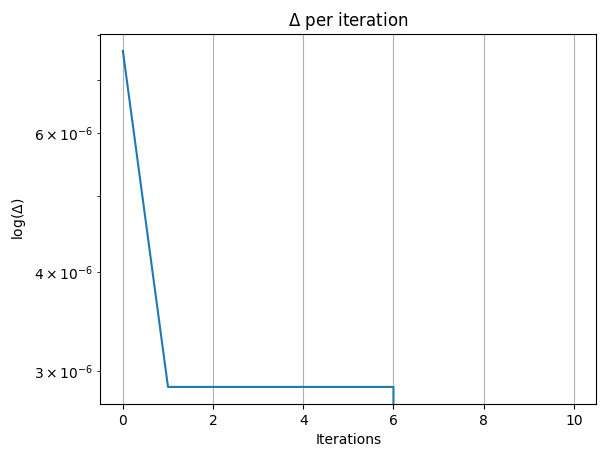

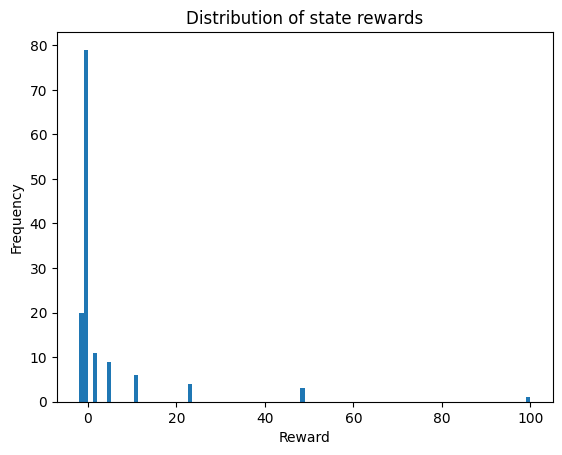

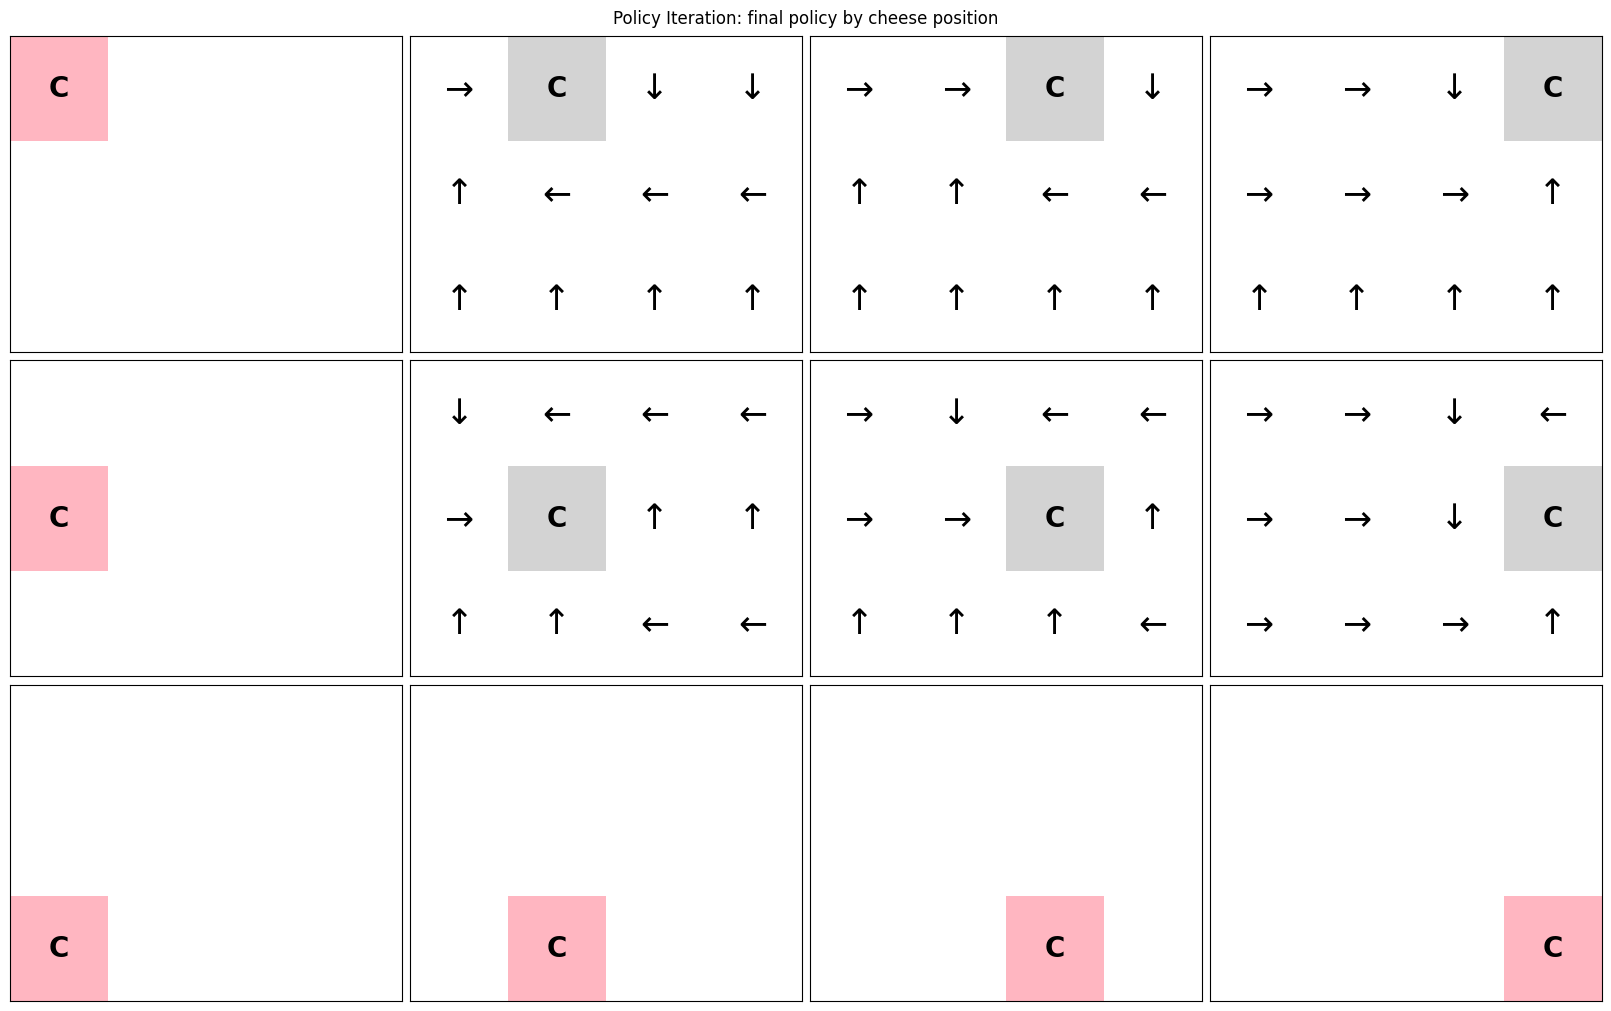

In [51]:
# Call Policy Iteration algorithm
env = MouseEnv()
theta = 1e-5
discount_rate = 0.5

final_policy, final_value_function, evaluation_delta_history, policy_stable = policy_iteration(env=env, theta=theta, gamma=discount_rate, max_iterations=20)

print(f"Policy Iteration iterations: {len(evaluation_delta_history)}")
print(f"Final policy stable: {policy_stable}")

# Plot final evaluation deltas (per iteration)
plot_convergence(evaluation_delta_history)
plt.show()

# Plot distribution of values for the converged policy
plot_state_value(final_value_function)
plt.show()

# Plot final policy in a 4x3 grid (one plot per cheese position)
plot_policy(final_policy, title="Policy Iteration: final policy by cheese position")
plt.show()

In [52]:
# Call Value Iteration algorithm

_In this cell, describe how the algorithms work, how the algorithms differ, plot results and/or policies (add more code cells!), etc._

# 3. Monte Carlo algorithms

First run the Monte Carlo algorithm (Monte Carlo Exploring Starts or Monte Carlo without Exploring Starts (with $\epsilon$-greedy strategy)) by calling functions from the separate `mc.py` file, and create plots. Then, fill in the cell completing your 'report' within this file.

In [53]:
# Call Monte Carlo algorithm

_In this cell, describe how the algorithms work, how the algorithms differ (compared to the one you did not code), plot results and/or policies (add more code cells!), etc._

# 4. Temporal Difference algorithms

First run the Temporal Difference algorithms (SARSA and Q-learning) by calling functions from the separate `td.py` file, and create plots. Then, fill in the cell completing your 'report' within this file.

In [54]:
# Call SARSA algorithm

In [55]:
# Call Q-learning algorithm

# 5. Comparison and discussion

Compare different algorithms (MC and TD with plots). You don’t need to plot DP alongside MC and TD since DP is not a learning algorithm. However, DP can provide the ground truth for optimal state or action values, which can serve as a reference when evaluating MC and TD. You can choose to plot any of the following: cumulative reward, root mean squared error, sample efficiency, or any other metric you think is a fair comparison.

Include a discussion: what can you conclude by comparing different RL algorithms? Do they have certain strengths or limitations?

_Add as many text cells as you like_

In [56]:
# Add as many code cells as you like

# 6. Conclusion

Conclude your project.

_Add as many text cells as you like_